<a href="https://colab.research.google.com/github/Abstract-code-ops/ECG-Classification/blob/main/DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import shutil
import datetime
from google.colab import drive
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import keras
from tensorflow.keras.regularizers import l2
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
import joblib
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with zipfile.ZipFile("drive/MyDrive/jupy_all.zip", 'r') as zip_ref:
    zip_ref.extractall("..")

In [ ]:
# # Path to the CSV file
# metadata_path = 'path_to_dataset/ptbxl_database.csv'
# # Load the metadata
# metadata = pd.read_csv(metadata_path)

NameError: name 'pd' is not defined

In [ ]:
try:
  shutil.rmtree('logs')
except:
  print('all good')

all good


In [ ]:
def load_data(path, label_dict):
    data = []
    label = []
    for cat, label_value in label_dict.items():
        pic_list = os.path.join(path, cat)
        for img in os.listdir(pic_list):
            image_path = os.path.join(pic_list, img)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))
            data.append(image)
            label.append(label_value)
    return np.array(data), np.array(label)

In [ ]:
label_dict = {
    'HB': 0,
    'MI': 1,
    'Normal': 2,
    'PMI': 3
}

path = os.path.join("..", "jupy_all")

data, label = load_data(path, label_dict)
data, label = shuffle(data, label, random_state=42)  # Shuffle the data and labels together
data = data.astype('float32') / 255.0
num_classes = len(label_dict)
label = keras.utils.to_categorical(label, num_classes)
train_data, test_data, train_label, test_label = train_test_split(data, label, test_size=0.35, random_state=42)
train_data_flatten = train_data.reshape(train_data.shape[0], -1)
test_data_flatten = test_data.reshape(test_data.shape[0], -1)

path2 = os.path.join("..", "jupy_all", "check")

check_data,check_label = load_data(path2,label_dict)
check_data=check_data.astype('float32')/255.0
num_classes=len(label_dict)
check_label=keras.utils.to_categorical(check_label,num_classes)
check_data, check_label = shuffle(check_data, check_label, random_state=42)

datagen = ImageDataGenerator(
    width_shift_range=0.2,  # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,  # Shearing
    brightness_range=[0.8, 1.2],  # Brightness adjustment
    channel_shift_range=50.0,  # Channel shift
    fill_mode='nearest'  # Filling mode for transformations
)
datagen.fit(train_data)

In [ ]:
svm_model = SVC(kernel='rbf', C=1.0, random_state=42, probability=True)
svm_model.fit(train_data_flatten, np.argmax(train_label, axis=1))
svm_accuracy = svm_model.score(test_data_flatten, np.argmax(test_label, axis=1))
print("SVM Accuracy:", svm_accuracy)
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=num_classes, random_state=42)
xgb_model.fit(train_data_flatten, np.argmax(train_label, axis=1))
xgb_accuracy = xgb_model.score(test_data_flatten, np.argmax(test_label, axis=1))
print("XGBoost Accuracy:", xgb_accuracy)
base_estimator = DecisionTreeClassifier(max_depth=5)
adaboost_model = AdaBoostClassifier(estimator=base_estimator, n_estimators=50, random_state=42)
adaboost_model.fit(train_data_flatten, np.argmax(train_label, axis=1))
adaboost_accuracy = adaboost_model.score(test_data_flatten, np.argmax(test_label, axis=1))
print("AdaBoost Accuracy:", adaboost_accuracy)

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 64)      256       
 chNormalization)                                                
                                                        

In [ ]:
final_model = VotingClassifier(
    estimators=[('AdaBoostClassifier', adaboost_model), ('xgb', xgb_model), ('svm', svm_model), ("cnn", model)], voting='hard')

final_model.fit(train_data_flatten, np.argmax(train_label, axis=1))

final_model.score(test_data_flatten, np.argmax(test_label, axis=1))

0.9612903225806452

In [ ]:
joblib.dump(final_model, "final_model_hard.joblib")

['final_model_hard.joblib']

In [ ]:
final_model2 = VotingClassifier(
    estimators=[('AdaBoostClassifier', adaboost_model), ('xgb', xgb_model), ('svm', svm_model)], voting='soft')

final_model2.fit(train_data_flatten, np.argmax(train_label, axis=1))

final_model2.score(test_data_flatten, np.argmax(test_label, axis=1))

0.9720430107526882

In [ ]:
joblib.dump(final_model2,"final_model_soft.joblib")

NameError: name 'joblib' is not defined

In [ ]:
score_accuracy1 = final_model.score(test_data_flatten, np.argmax(test_label, axis=1))
score_accuracy2 = final_model2.score(test_data_flatten, np.argmax(test_label, axis=1))

In [ ]:
model.save("ecg_model.keras")

In [ ]:
def translate_list(input_list):
    translate_dict = {
        0: 'HB',
        1: 'Myocardial Infarction',
        2: 'Normal Heartbeat',
        3: 'History of MI'
    }

    return [translate_dict[n] for n in input_list]

In [ ]:
!nvidia-smi

Wed Jul 17 16:50:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0              32W /  70W |    107MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import joblib

# Save the SVM model
joblib.dump(svm_model, "svm_model.pkl")

# Save the XGBoost model
xgb_model.save_model("xgb_model.json")
xgb_model.save_model("xgb_model.keras")

# Save the AdaBoost model
# joblib.dump(adaboost_model, "adaboost_model.pkl")
# adaboost_model.save_model("adaboost_model.keras")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [09:46:31] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [ ]:
image_path = "../content/normal.jpeg"

# Load the image
image = cv2.imread(image_path)

# Check if the image was successfully loaded
if image is None:
    print(f"Error: Unable to load image at {image_path}")
else:
    # Preprocess the image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = cv2.resize(image, (224, 224))           # Resize the image to the input size of the model
    image = image.astype('float32') / 255.0         # Normalize the image
    image = np.expand_dims(image, axis=0)           # Add batch dimension

    predictions = model.predict(image)

    predicted_class_indices = np.argmax(predictions, axis=1)

        Translate indices to labels
    predicted_labels = translate_list(predicted_class_indices)

    print(predicted_labels)


1/1 [==============================] - 0s 201ms/step
['History of MI']


In [ ]:
model = load_model("ecg_model.keras")
svm_model = joblib.load("svm_model.pkl")
xgb_model = xgb.Booster()
xgb_model.load_model("xgb_model.json")

In [ ]:
def predict_svm(model, image):

    # Check if the image was successfully loaded
    if image is None:
        print(f"Error: Unable to load image at")
    else:
        # Preprocess the image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        image = cv2.resize(image, (224, 224))           # Resize the image to the input size of the model
        image = image.astype('float32') / 255.0         # Normalize the image
        image = np.expand_dims(image, axis=0)           # Add batch dimension

        image = image.reshape(1, -1)

        predictions = model.predict(image)

        predicted_class_index = predictions[0]

        # Translate index to label
        predicted_label = translate_list([predicted_class_index])[0] # Wrap in a list for translate_list function

        print(predicted_label)
        return predicted_label

In [ ]:
def predict_cnn(model, image):
    # Check if the image was successfully loaded
    if image is None:
        print(f"Error: Unable to load image at")
    else:
        # Preprocess the image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        image = cv2.resize(image, (224, 224))           # Resize the image to the input size of the model
        image = image.astype('float32') / 255.0         # Normalize the image
        image = np.expand_dims(image, axis=0)           # Add batch dimension

        # Removed the line that was flattening the image
        # image = image.reshape(1, -1)

        predictions = model.predict(image)

        predicted_class_index = np.argmax(predictions, axis=1)[0] # Get the index with highest probability

        # Translate index to label
        predicted_label = translate_list([predicted_class_index])[0] # Wrap in a list for translate_list function

        print(predicted_label)
        return predicted_label # Return the predicted label


In [ ]:
def predict_xgb(model, image):
    # Load the image

    # Check if the image was successfully loaded
    if image is None:
        print(f"Error: Unable to load image at")
    else:
        # Preprocess the image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        image = cv2.resize(image, (224, 224))           # Resize the image to the input size of the model
        image = image.astype('float32') / 255.0         # Normalize the image
        image = np.expand_dims(image, axis=0)           # Add batch dimension

        image = image.reshape(1, -1)

        # Convert NumPy array to DMatrix object
        image_dmatrix = xgb.DMatrix(image)  # Create DMatrix for XGBoost

        predictions = model.predict(image_dmatrix)  # Use DMatrix for prediction

        predicted_class_index = predictions[0]

        # Translate index to label
        predicted_label = translate_list([predicted_class_index])[0] # Wrap in a list for translate_list function

        print(predicted_label)
        return predicted_label

In [ ]:
check_loss, check_accuracy = model.evaluate(check_data, check_label)

xgb_predictions = xgb_model.predict(xgb.DMatrix(test_data_flatten))
xgb_predicted_classes = xgb_predictions
# Calculate accuracy for XGBoost model
xgb_accuracy = accuracy_score(np.argmax(test_label, axis=1), xgb_predicted_classes)
print("xgb accuracy",xgb_accuracy)

svm_accuracy = svm_model.score(test_data_flatten, np.argmax(test_label, axis=1))
print("SVM Accuracy:", svm_accuracy)

2/2 [==============================] - 2s 556ms/step - loss: 0.2457 - accuracy: 0.9792
xgb accuracy 0.9870967741935484
SVM Accuracy: 0.967741935483871


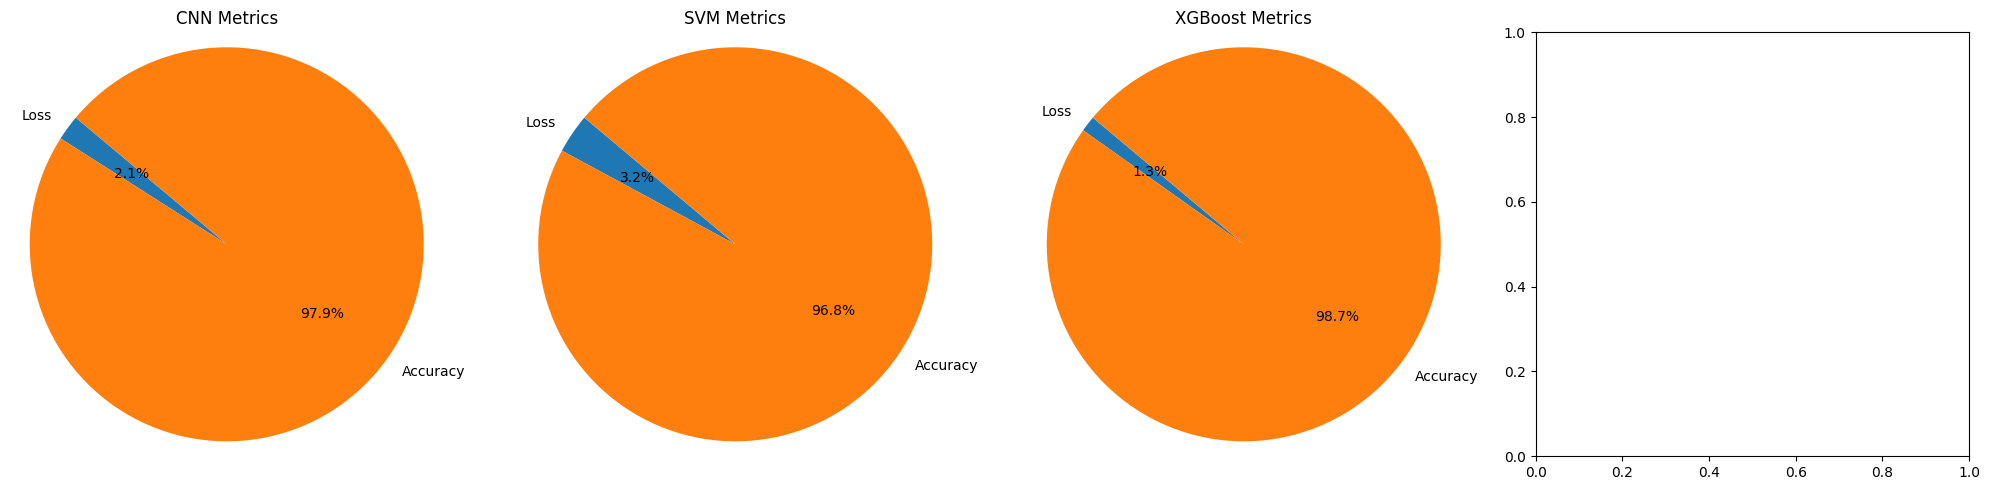

In [ ]:
# Test loss and accuracy of all four models
test_metrics = [(1 - check_accuracy,check_accuracy ), (1 - svm_accuracy, svm_accuracy),
                (1 - xgb_accuracy, xgb_accuracy), (1 - score_accuracy1, score_accuracy1),
                (1 - score_accuracy2, score_accuracy2)]
model_names = ['CNN', 'SVM', 'XGBoost', 'Voting Hard', 'Voting Soft']

# Plotting the pie chart
# Plotting the pie charts side by side
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for ax, (loss, accuracy), model_name in zip(axes, test_metrics, model_names):
    ax.pie([loss, accuracy], labels=['Loss', 'Accuracy'], autopct='%1.1f%%', startangle=140)
    ax.set_title(f'{model_name} Metrics')
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.tight_layout()
plt.show()

In [ ]:
# Create a file upload widget
uploader = widgets.FileUpload(
    accept='image/*',  # Accept only image files
    multiple=False     # Allow only one file upload
)

# Display the upload widget
display(uploader)

# Define a function to handle file upload
def handle_upload(change):
    # Check if a file was uploaded
    if uploader.value:
        # Get the first (and only) uploaded file's info
        file_info = next(iter(uploader.value.values()))

        # Read the image
        image = cv2.imdecode(np.frombuffer(file_info['content'], np.uint8), cv2.IMREAD_COLOR)

        predictions_svm = predict_svm(svm_model, image)
        predictions_cnn = predict_cnn(model, image)
        predictions_xgb = predict_xgb(xgb_model, image)

# Register the upload handler
uploader.observe(handle_upload, names='value')

FileUpload(value={}, accept='image/*', description='Upload')

HB
1/1 [==============================] - 0s 72ms/step
History of MI
HB
HB
1/1 [==============================] - 0s 66ms/step
Normal Heartbeat
HB
